# Feature selection

Pro 2 dimenze umíme chování funkce vizualizovat dobře, viz např. matice hexbinplotů v úvodu. Techniky *výběru rysů* (angl. feature selection) nám umožní vybrat dvě dimenze, které jsou z nějakého pohledu ty "nejzajímavější". Narozdíl od obecnějších technik *extrakce rysů* (angl. feature extraction), budou vybrané dimenze vždy již mezi těmi vstupními.

Pojem "nejzajímavější dimenze" může znamenat ledacos, např. nejinformativnější vzhledem k vlivu na funkční hodnotu. Ale i nejinformativnější může znamenat ledacos. To uvidíme u jednotlivých technik. Obecný postup spočívá v natrénování nějakého statistkého regresoru a zvolení dvou dimenzí, kterým byla přiřazena největší váha.

## Příprava notebooku

In [117]:
%matplotlib inline

In [118]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [119]:
sns.set(style='white')

## Načtení dat

In [120]:
d1 = pd.read_csv('data/data1.csv', sep=';', header=None)
n = 13  # number of inputs
input_indices = list(range(n))
x = d1[input_indices]
y = d1[n]

## Korelace

Nejprve se podívme na to, jak moc korelují jednotlivé vstupní dimenze s výstupní hodnotou.

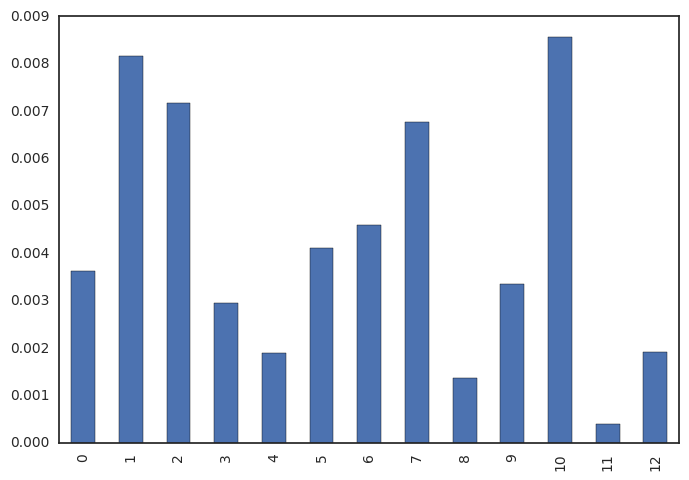

In [121]:
d1.corr().abs()[13][input_indices].plot(kind='bar')

Vidíme, že s funkční hodnotou nejvíce korelují dimenze 1 a 10. Můžeme si teď vykreslit všechny body zprojektované do dimenzí 1 a 10. Každý bod obarvíme podle jeho funkční hodnoty.

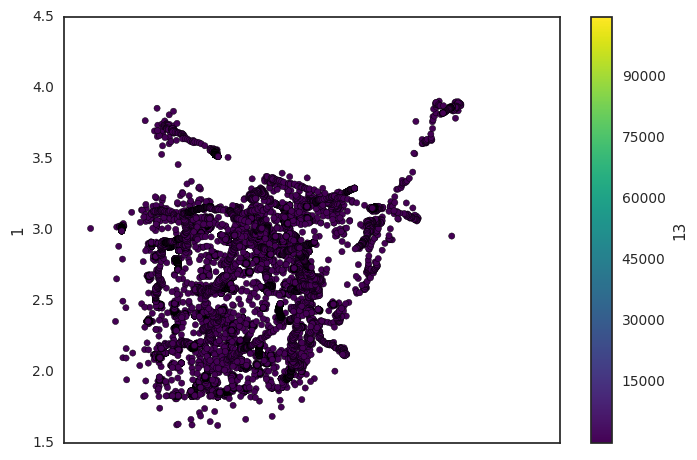

In [122]:
d1.plot.scatter(x=10, y=1, c=n, cmap='viridis')

Tím, že jsme velký počet dimenzí zredukovali na pouhé dvě, dostalo se spousta bodů přes sebe a tak v tomto grafu není nic moc vidět. Všechny vysoké hodnoty jsou zakryté hromadou těch nízkých. Řešením je hexbinplot, který pro každý úsek dvojdimenzionální plochy zobrazí maximální dosažené hodnoty (případně průměrnou hodnotu).

In [123]:
def interactive_hexbin_plot(df, x, y, C=n):
    def plot_hexbin(gridsize, logscale, maximum):
        df.plot.hexbin(x=x, y=y, C=C,
                      bins='log' if logscale else None,
                      gridsize=gridsize,
                      reduce_C_function=np.max if maximum else np.mean,
                      cmap='viridis')

    gridsize = widgets.IntSlider(min=10, max=100, step=5, value=25, description='grid size')
    widgets.interact(plot_hexbin, gridsize=gridsize, logscale=True, maximum=True)

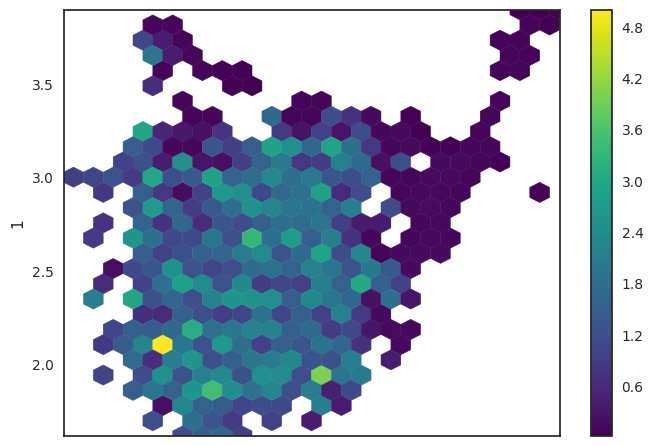

In [124]:
interactive_hexbin_plot(d1, x=10, y=1)

Korelace ale popisuje lineární závislost a závislost mezi vstupními dimenzemi a funkční hodnotou může být zcela nelineární. Což je i náš případ, na grafu korelací výše vidíme, že jednotlivé korelace jsou mizivé (< 0.01).

V dalších částech prozkoumáme další míry "zajímavosti", které lze místo korelace použít: F-hodnotu, *mutual-information* a *Gini-index*.

## F-hodnota

F-hodnota odpovídá váze natrénovaného lineárního regresoru a jde tak pouze o upravenou korelaci mezi každou vstupní dimenzí a funkční hodnotou. P-hodnota pak popisuje pravděpodobnost pozorované korelace, pokud by skutečná korelace byla nulová. Takže dimenze je pro lineární regresi tím důležitější, čím je F-hodnota větší a čím je p-hodnota menší. Podívejme se na graf F-hodnot a p-hodnot:

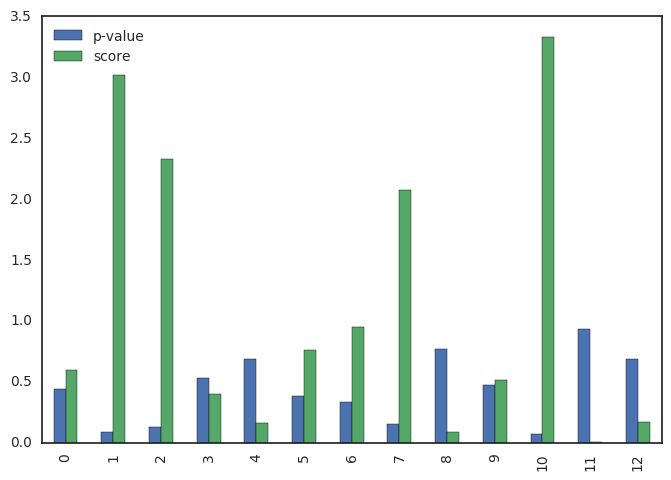

In [125]:
dimensions_selector = SelectKBest(f_regression, k=2)
dimensions_selector.fit(x, y)
pvalues = pd.Series(dimensions_selector.pvalues_, name='p-value')
scores = pd.Series(dimensions_selector.scores_, name='score')
dim_info = pd.concat([pvalues, scores], axis=1)
dim_info.plot(kind='bar')

Největší skóre (a nejmenší p-hodnotu) mají dimenze 10 a 1.
To je stejný výsledek jako u korelace, což není překvapivé, protože F-hodnota se počítá z korelace.

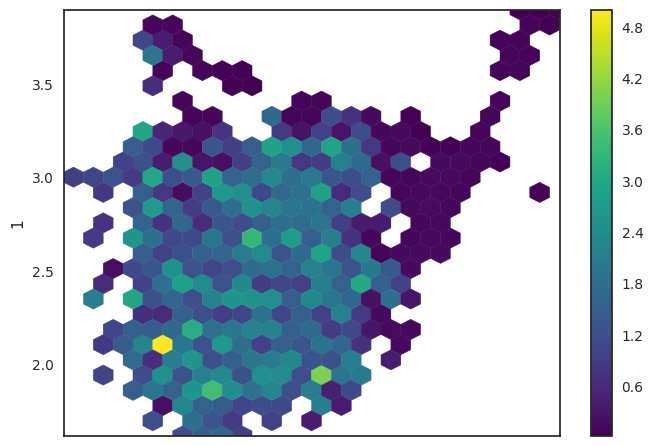

In [126]:
interactive_hexbin_plot(d1, x=10, y=1)

## Vzájemná informace

Vzájemná informace (angl. [mutual-information](https://en.wikipedia.org/wiki/Mutual_information)) je metrika vyjadřující, jak znalost jedné proměnné snižuje nejistotu ohledně hodnoty druhé proměnné. Základní výhodou oproti korelaci a F-hodnotě je, že umí zachytit libovolnou závislost, nikoliv jen tu lineární. Nevýhodou je složitější, časově náročnější výpočet.

Vypočtěme si tedy vzájemnou informaci mezi každou ze vstupních proměnných a funkční hodnotou:

0     3.404539
10    2.964799
5     2.928335
9     2.902886
1     2.896619
6     2.872758
3     2.858247
8     2.820112
11    2.803946
12    2.779271
4     2.773454
7     2.752495
2     2.737586
Name: score, dtype: float64


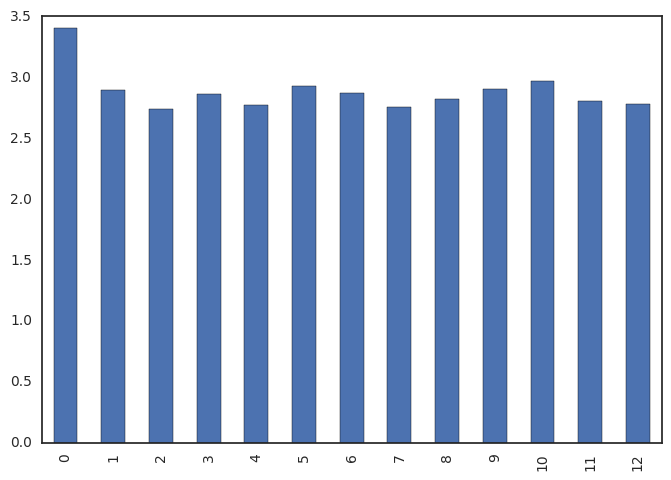

In [127]:
dimensions_selector_mi = SelectKBest(mutual_info_regression, k=2)
ds = d1.sample(10000, random_state=0)
xs = ds[input_indices]
ys = ds[n]
dimensions_selector_mi.fit(xs, ys)
scores_mi = pd.Series(dimensions_selector_mi.scores_, name='score')
print(scores_mi.sort_values(ascending=False))
scores_mi.plot(kind='bar')

Největší skóre teď mají dimenze 0 a 10. Projekce funkce do prostoru daného těmito dvěma dimenzemi vypadá následovně:

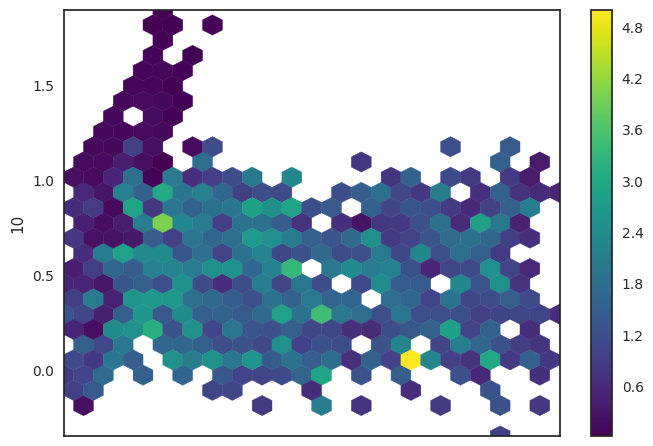

In [128]:
interactive_hexbin_plot(d1, x=0, y=10)

## Rozhodovací stromy

Dalším modelem, který lze použít pro výběr rysů jsou regresní rozhodovací stromy (angl. decision trees). Naučený regresor opět poskytuje informaci o důležitosti rysů, podle toho, jak moc která vstupní dimenze přispívá k celkovému rozhodnutí o predikované hodnotě. Této metrice se říká *Gini importance*.

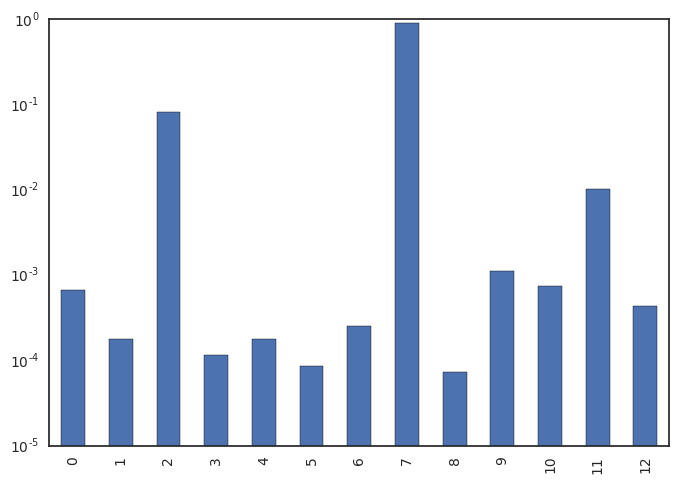

In [129]:
tree_model = DecisionTreeRegressor()
tree_model = tree_model.fit(x, y)
pd.Series(tree_model.feature_importances_).plot(kind='bar', logy=True)

Problém rozhodovacího stromu je ten, že není stabilní, každý běh může skončit se značně jiným stromem a tedy značně jinými důležitostmi dimenzí. Řešením je les stromů!

## Náhodný les

Náhodný les (angl. *random forest*) je model, který průměruje hodnoty z mnoha rozhodovacích stromů, při jejichž učení bylo využito náhodnosti. Náhodný les je vhodnější pro výběr rysů než rozhdovací strom, protože díky průměrování velkého množství stromů je vypočtená důležitost jednotlivých rysů robustnější (má menší rozptyl).

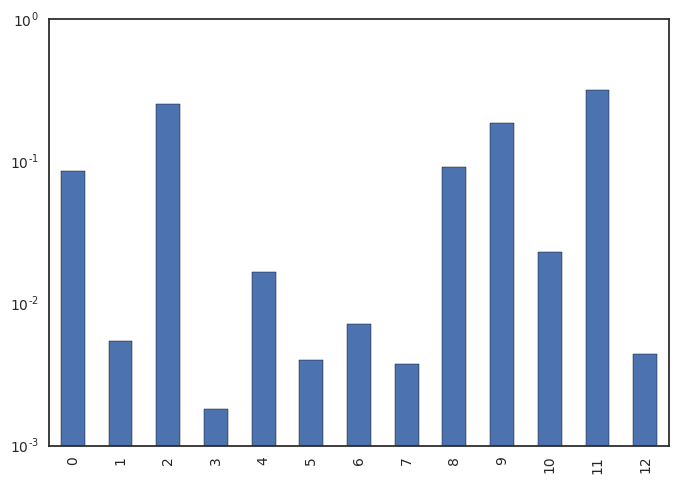

In [130]:
forest_model = RandomForestRegressor(random_state=0)
forest_model = forest_model.fit(x, y)
pd.Series(forest_model.feature_importances_).plot(kind='bar', logy=True)

Nejvýznamnější dimenze: 11 a 2

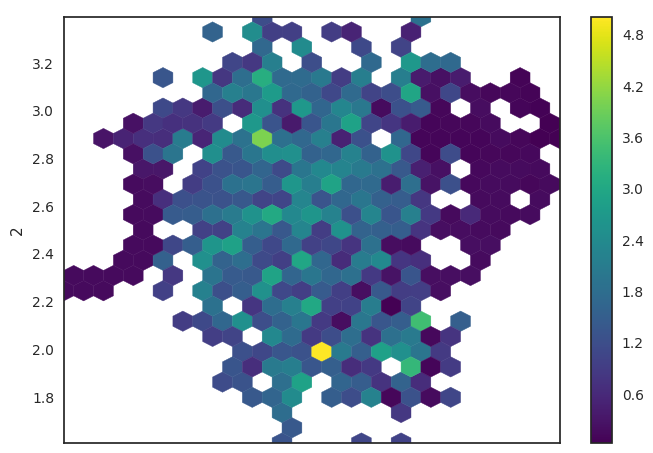

In [131]:
interactive_hexbin_plot(d1, x=11, y=2)

## Výsledky

Přehled nejvýznamnějších dimenzí podle různých metrik:

| Metrika (model) | d1 | d2 |
|---|---|---|
| Korelace / F-hodnota (lineární regrese)  | 10 | 1 |
| Vzájemná informace | 0 | 10 |
| Gini importance (Náhodný les) | 11 | 2 |

Provedené analýzy můžeme také využít tak, že zjednodušíme graf z úvodu, který zobrazoval projekci na všechny dvojice vstupních hodnot. Omezíme se jen na několik dimenzí, které se podle analýz zdají být nejzajímavější. Navíc budeme zobrazovat zlogaritmované funkční hodnoty.

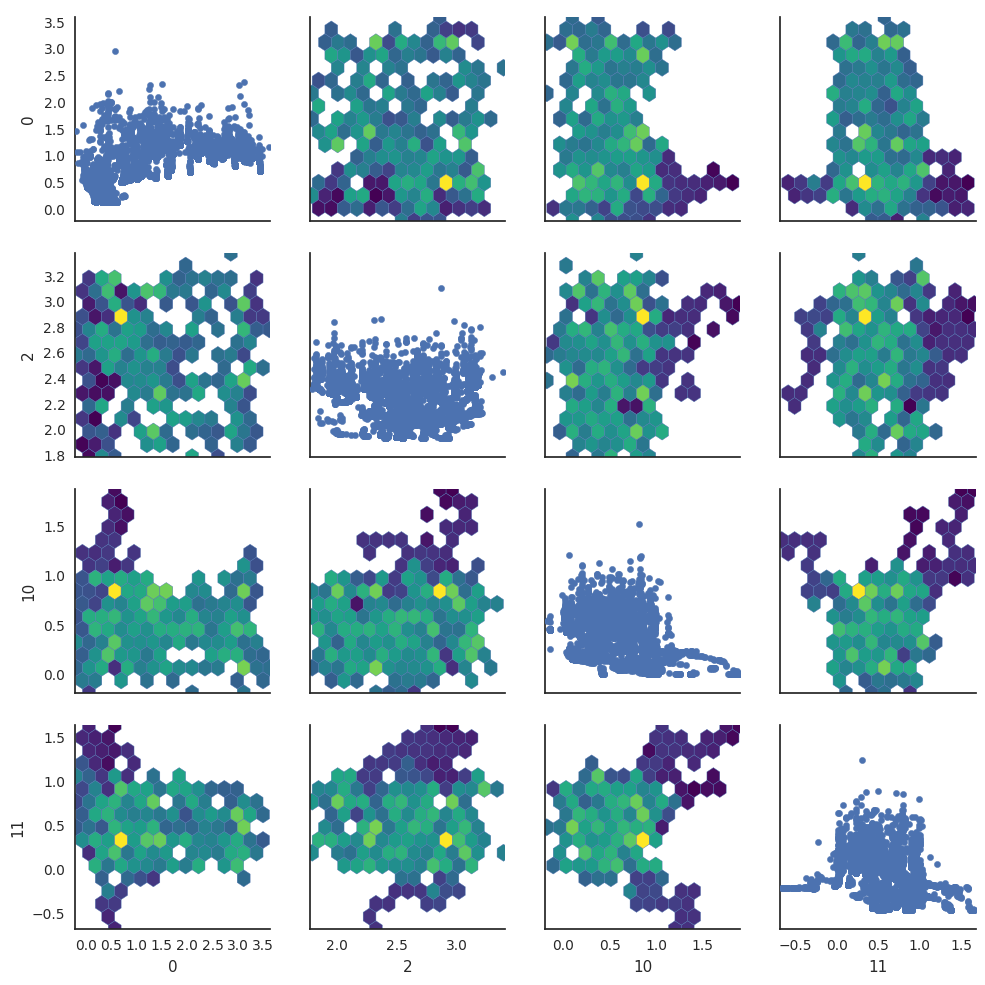

In [132]:
ds = d1.sample(10000, random_state=0)
y_log = ds[n].apply(np.log)
g = sns.PairGrid(ds, vars=[0, 2, 10, 11])
g = g.map_diag(plt.scatter, y=y_log)
g = g.map_offdiag(plt.hexbin, C=y_log, reduce_C_function=np.max, gridsize=15, cmap='viridis')

## Větší dataset

Zkusme pomocí uvedených technik výběru rysů prozkoumat ještě druhý dataset. Protože je mnohonásobně větší, některé výpočty by trvaly dlouho. To lze vyřešit náhodným nasemplováním části bodů.

In [133]:
d2 = pd.read_csv('data/data2.csv', sep=';', header=None)
x2, y2 = d2[input_indices], d2[n]
ds2 = d2.sample(10000, random_state=0)
xs2, ys2 = ds2[input_indices], ds2[n]

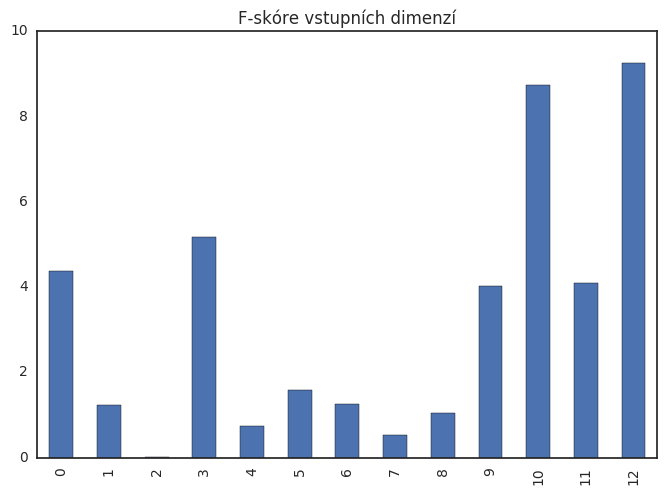

In [134]:
plt.title('F-skóre vstupních dimenzí')
dimensions_selector.fit(x2, y2)
pd.Series(dimensions_selector.scores_, name='score').plot(kind='bar')

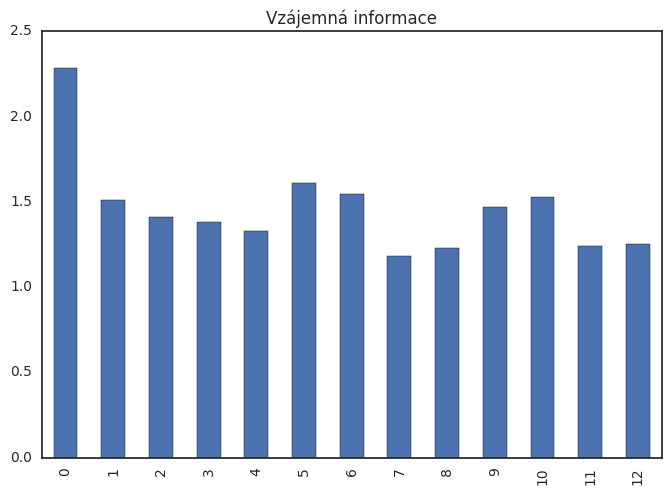

In [135]:
plt.title('Vzájemná informace')
dimensions_selector_mi.fit(xs2, ys2)
scores_mi = pd.Series(dimensions_selector_mi.scores_, name='score')
scores_mi.plot(kind='bar')

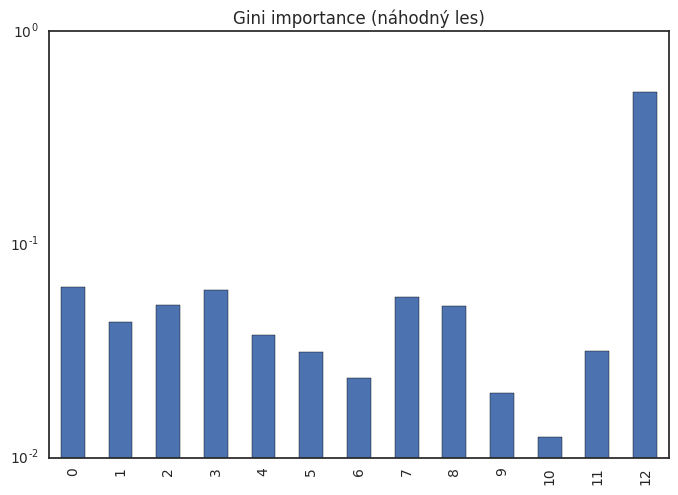

In [136]:
plt.title('Gini importance (náhodný les)')
forest_model = forest_model.fit(xs2, ys2)
pd.Series(forest_model.feature_importances_).plot(kind='bar', logy=True)

Přehled nejvýznamnějších dimenzí podle různých metrik:

| Metrika (model) | d1 | d2 |
|---|---|---|
| Korelace / F-hodnota (lineární regrese)  | 12 | 10 |
| Vzájemná informace | 0 | 5 |
| Gini importance (Náhodný les) | 12 | 0 |

Jako dvě nejzajímější dimenze se zdají 0 a 5, vykresleme si tedy nejprve graf zprojektovaný do těchto dvou dimenzí:

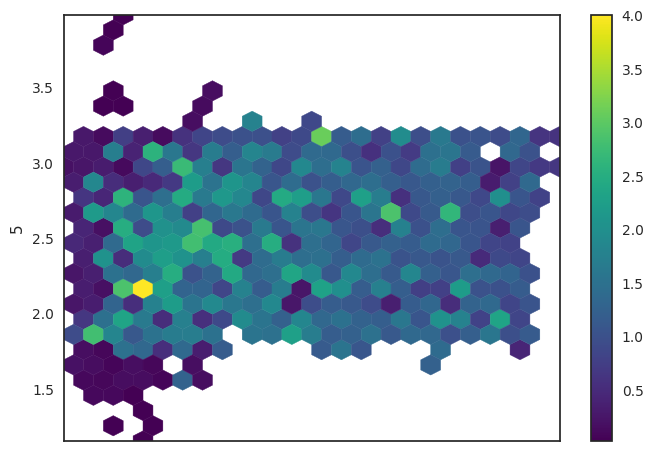

In [137]:
interactive_hexbin_plot(ds2, x=0, y=5)

Nebo můžeme vykreslit projekce pro všechny dvojice z těch nejzajímavějších dimenzí:

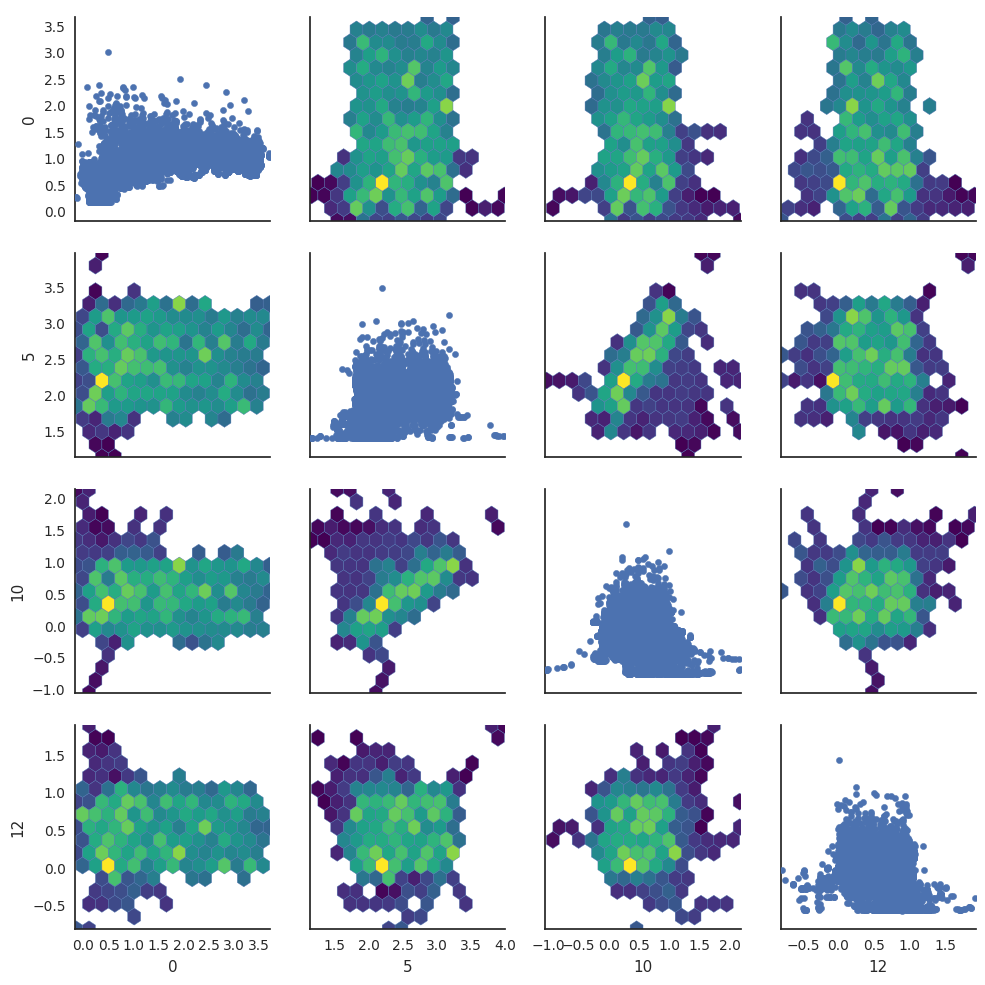

In [138]:
y2_log = ds2[n].apply(np.log)
g = sns.PairGrid(ds2, vars=[0, 5, 10, 12])
g = g.map_diag(plt.scatter, y=y2_log)
g = g.map_offdiag(plt.hexbin, C=y2_log, reduce_C_function=np.max, gridsize=15, cmap='viridis')